#  Streaming Mode in G-API Python

## Introduction of Streaming Mode

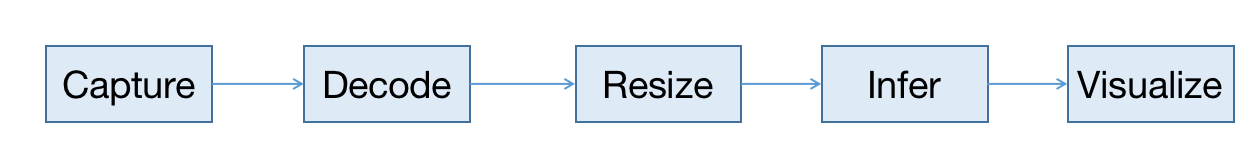

In [18]:
from IPython.display import Image
image_path = '/Users/anna/tutorials-py/resources/streaming1.png'
Image(filename=image_path)

Streaming is a prominent feature of G-API. With the streaming feature, users can shift the execution model of G-API from a regular mode to a streaming mode. In the regular mode, G-API processes an entire image at once, then proceeds to the next one. However, in the streaming mode, G-API processes multiple images consecutively, creating a pipeline of image processing.

The advantage of the Streaming mode is that it can fully utilize system resources and increase processing speed. Under streaming mode, G-API processes images as parallel as possible. For instance, while one image is undergoing the second operation, another image might have already commenced the first operation, enabling efficient use of system resources and improved processing efficiency.

G-API's Streaming mode is especially suitable for dealing with continuous image streams, such as video streams or continuous images captured by cameras. With the streaming mode, users can more easily develop high-performance real-time image processing and computation applications.

## Anatomy of a regular video analytics application

Here's a brief overview of these steps:

**Capture**: This is the first step in any video analytics application. The capture process involves obtaining video data from a source, which can be a physical device such as a camera, a video file, or a network stream.

**Decode**: Video data is usually compressed to save space and bandwidth. The decoding process involves translating this compressed data into a raw format that can be used for further processing. This step is crucial to the workflow because other processes can't start without the raw data.

**Resiz**e: To ensure the computational efficiency of the subsequent steps, the raw video frames are often resized. Depending on the specific analytics task and the computational resources available, video frames might be scaled down (or sometimes up) to a more manageable size.

**Infer**: In the inference step, video frames are inputted into an analytics model. The model processes these frames and makes predictions or "inferences". This could include object detection, activity recognition, scene understanding, etc. The specifics of the inference process depend on the algorithm or model in use.

**Visualize**: After the inference step, the results need to be presented in a human-readable way. This could involve overlaying bounding boxes on objects identified in a frame, displaying statistics about the video, or any other form of visualization that can make the results more understandable.

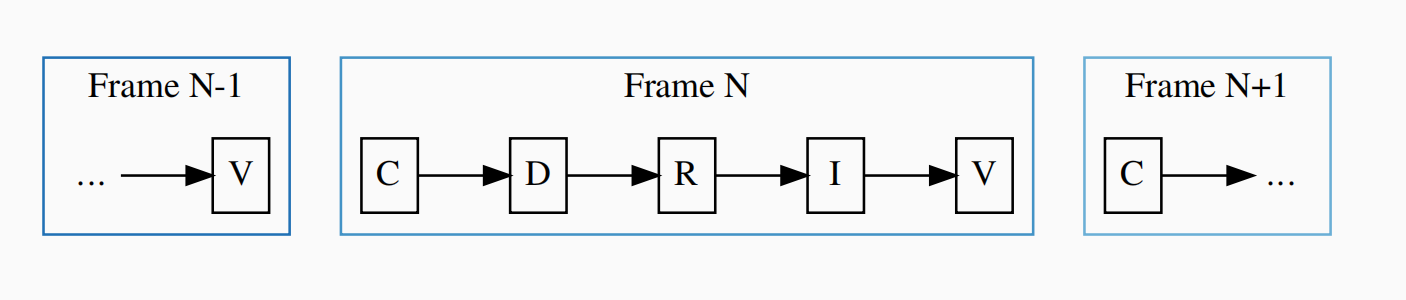

In [19]:
from IPython.display import Image
image_path = '/Users/anna/tutorials-py/resources/streaming2.png'
Image(filename=image_path)

In a serial execution of a sample video analytics application, each frame undergoes a sequence of steps before processing the next frame. The steps, represented by the initial letters, are: Capture (C), Decode (D), Resize (R), Infer (I), and Visualize (V). Here's what the sequence looks like:

* Frame N-1: First, frame N-1 is Captured, then Decoded, then Resized, an Inference is made, and finally, the result is Visualized.

* Frame N: Once the entire sequence for frame N-1 is complete, the same sequence starts for frame N.

* Frame N+1: Similarly, once frame N has been fully processed, the process starts for frame N+1.

In this model, every step of the pipeline for a given frame is completed before moving on to the next frame. This is a simple execution model, and can be effective for some use cases, but it may not take full advantage of all available system resources. Specifically, while one step of the pipeline is being processed, the resources not being used by that step remain idle.

For example, while frame N is being Decoded (a CPU-intensive task), the GPU might be idle. Then, when the Infer step (which is typically GPU-intensive) is running, the CPU might be idle. This is one of the motivations behind the development of more complex execution models, like Streaming in G-API, that aim to use resources more efficiently by overlapping the processing of different frames and different stages of the pipeline.

Understanding with Examples: Serial vs. Streaming Modes
Let's break down the differences between the "serial mode" and the "streaming mode" using the following examples, and see how each performs.

### Serial Mode
Think of "serial mode" like reading a book page-by-page. G-API gives results one-by-one when we trigger a ready-to-go item. We prepare this using the standard method, watch the video ourselves, and handle the steps of watching, tweaking, and showing the results one at a time

Let's look at Python code for Serial Mode.
```python
import cv2 as cv

def process_video(input_source: str, graph: cv.GComputation, kernels, networks):
    """
    Process a video or capturing device using OpenCV's Graph API.

    Args:
    - input_source (str): Path to the image or video source.
    - graph (cv.GComputation): OpenCV's GComputation object defining the computation.
    - kernels: Predefined computational kernels for processing.
    - networks: Neural networks for processing.

    Returns:
    None. It will display the processed frames in a window.
    """
    
    # Read an image from the given path.
    in_frame = cv.imread(input_source)
    
    # Open a video file or a capturing device or a IP video stream for video capturing.
    cap = cv.VideoCapture(input_source)
    
    # Compiling the graph to get an executable object.
    exec = graph.compile(cv.descr_of(in_frame), cv.compile_args(kernels, networks))
    
    # Initialization for the loop condition.
    ret = True

    # Loop to process each frame from the video or capturing device.
    while ret:
        # Executes the graph on the provided frame.
        exec(in_frame, out_frame)
        
        # Display the processed frame.
        cv.imshow("Out", out_frame)
        
        # Waits for a pressed key.
        cv.waitKey(1)
        
        # Read the next frame.
        ret, in_frame = cap.read()


```

### Streaming Mode
On the other hand, "streaming mode" is like water flowing through a pipe. G-API works in a continuous flow. It's different from the usual method but is actually more straightforward. We just set the process using *compileStreaming()*, which is different from the standard setup. Then, we choose where the information comes from. Once ready, we let it run, constantly pulling and showing results until there's no more data.


Let's look at Python code for Streaming Mode.
```python
import cv2 as cv

def process_stream(graph: cv.GComputation, g_capture_source: str):
    """
    Process a video stream using OpenCV's Graph API with GStreamer backend.

    Args:
    - graph (cv.GComputation): OpenCV's GComputation object defining the computation.
    - g_capture_source (str): GStreamer pipeline string for video capturing.

    Returns:
    None. It displays the processed frames in a window.
    """
    
    # Compile the provided graph for streaming.
    pipeline = graph.compileStreaming()
    
    # Create a GStreamer source using the provided pipeline string.
    source = cv.gapi.wip.make_gst_src(g_capture_source)
    
    # Set the created GStreamer source as the pipeline's source.
    pipeline.setSource(cv.gin(source))
    
    # Start the streaming pipeline.
    pipeline.start()
    
    # Pull the first frame from the streaming pipeline.
    has_frame, output = pipeline.pull()
    
    # Loop to process and display each frame from the stream.
    while has_frame:
        cv.imshow("Out", output)
        cv.waitKey(1)
        has_frame, output = pipeline.pull()

# Example usage (with placeholder values):
# graph = ...  # You'd define your GComputation here.
# g_capture_source = "your_gstreamer_pipeline_string_here"
# process_stream(graph, g_capture_source)

```

## Performance Overview

The sample's performance is influenced by various factors:

Device and precision used for inference, like CPU/INT8, CPU/FP32, or GPU/FP16.
Displaying the video stream on screen (with or without UI).
The chosen execution model: serial or streaming.


The Picture below provides a summary of the performance metrics for all 36 setups, gathered using an Intel® Core™ i5-6600 paired with OpenCV 4.4 and the Intel® Distribution of OpenVINO™ toolkit version 2020.4. The term "GPU" refers to the integrated Intel® Gen9 HD Graphics.

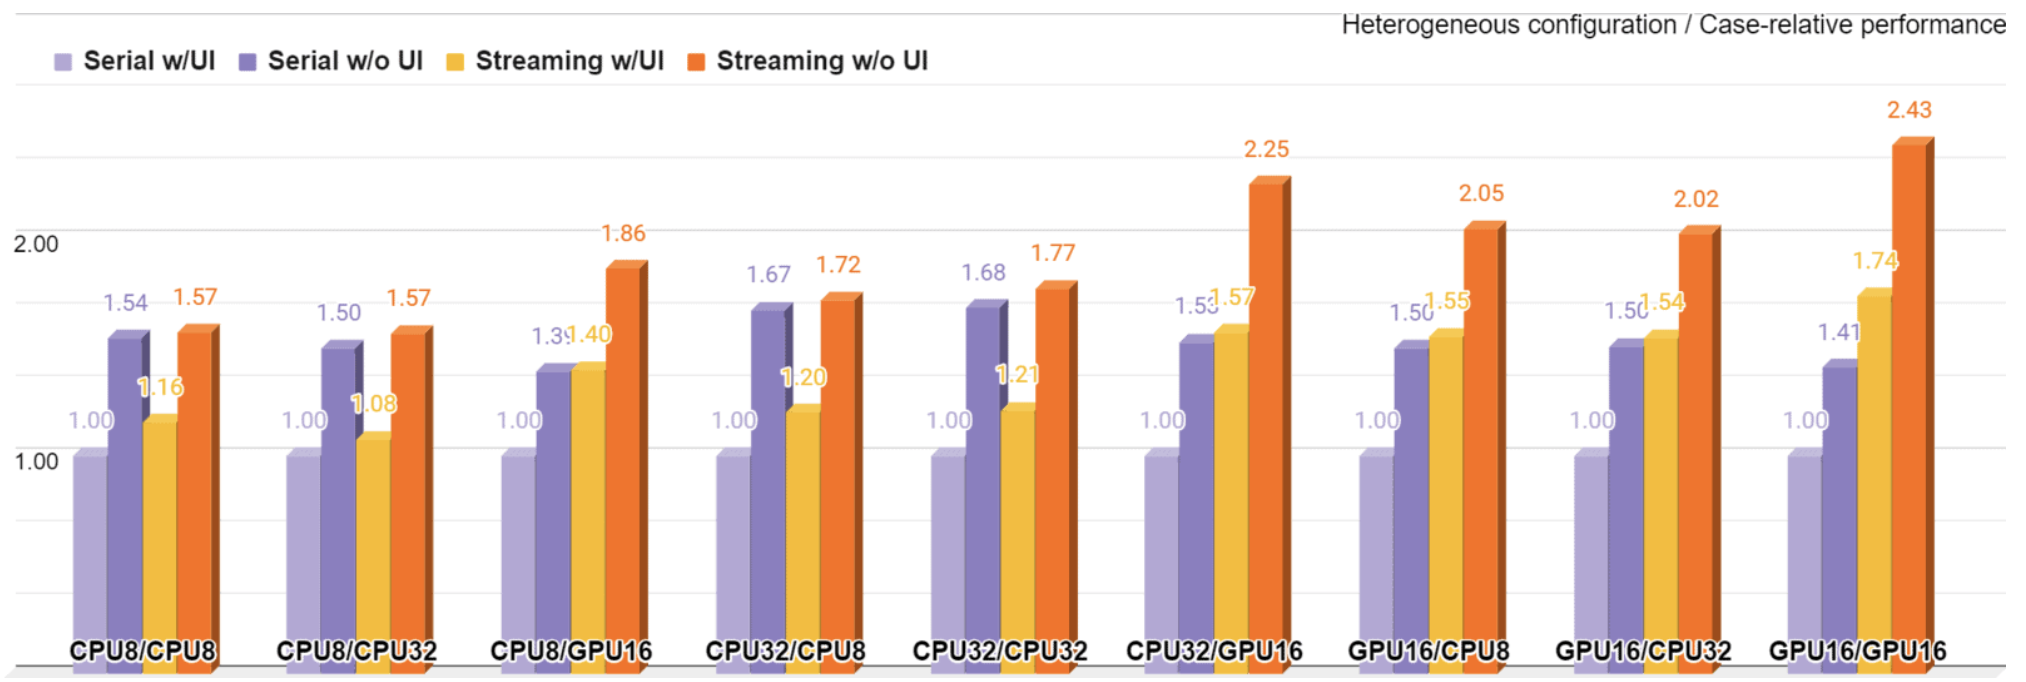

In [20]:
from IPython.display import Image
image_path = '/Users/anna/tutorials-py/resources/streaming3.png'
Image(filename=image_path)

The picture organizes data into nine categories, each representing a specific device+precision combination. For instance, "CPU8/GPU16" indicates FD on a CPU using INT8 precision and LPD on a GPU with FP16 precision. In every category, the baseline is the "Serial w/UI" mode, always marked at 1.0. This shows the performance improvement for each specific setting. Streaming mode enhances performance across all categories, especially evident in the “GPU16/GPU16” and “CPU32/GPU16” setups. Compared to previous picture, this picture highlights the overall system performance adjustments based on the settings. However, data remains organized into nine categories, enabling inter-category comparison. The peak performance occurs in the streaming mode without UI in the “CPU32/GPU16” scenario.

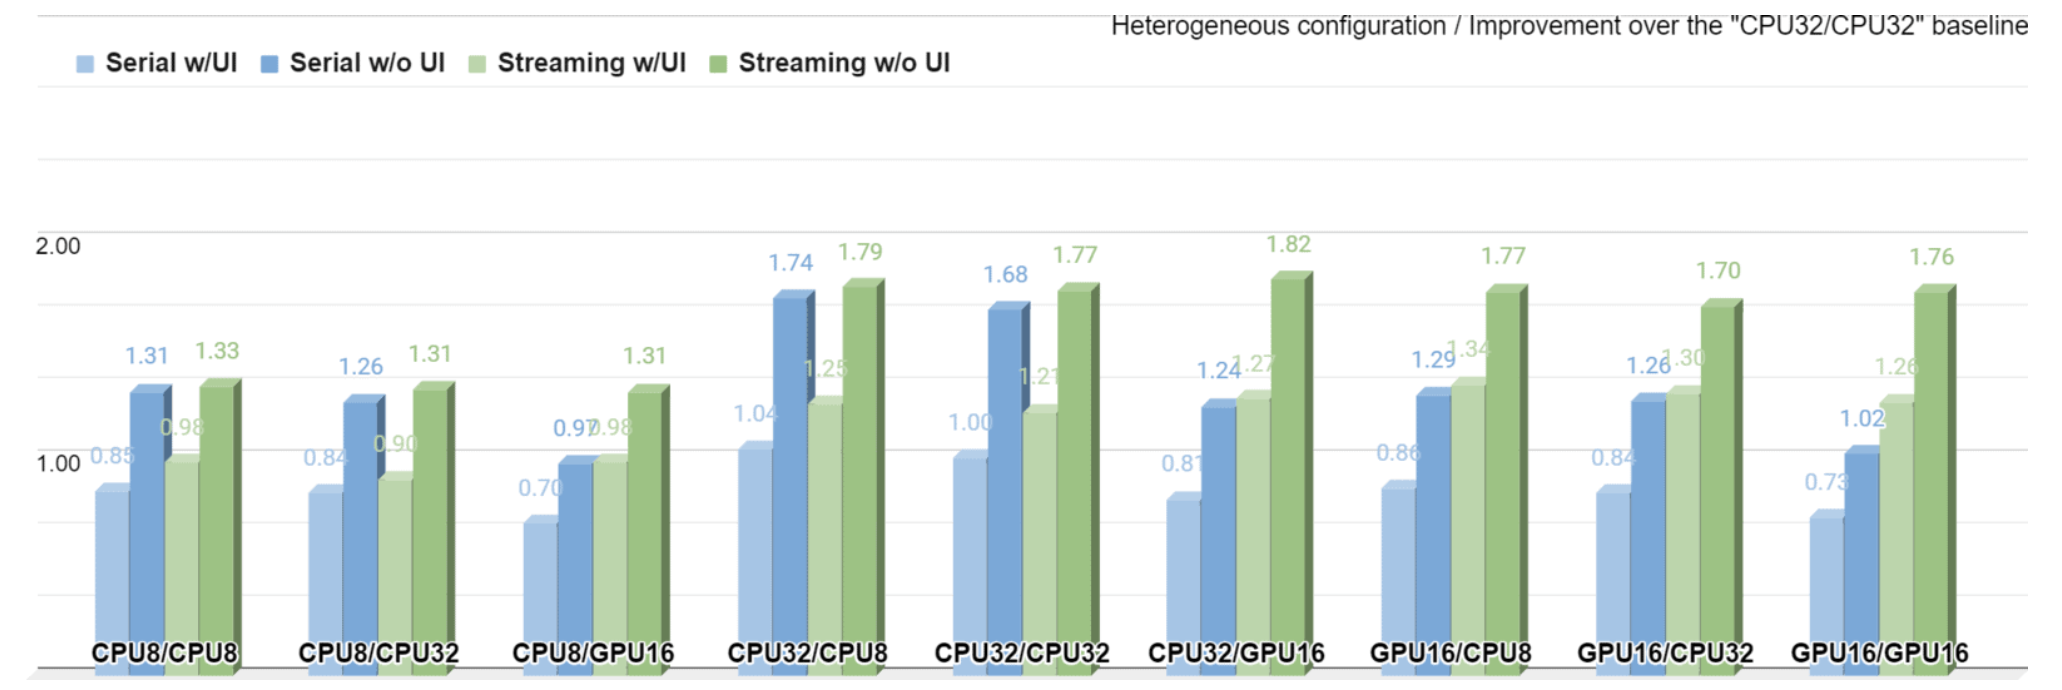

In [21]:
from IPython.display import Image
image_path = '/Users/anna/tutorials-py/resources/streaming4.png'
Image(filename=image_path)

Notably, in the "CPU*/CPU*" situations, both Serial and Streaming performance is almost identical due to shared execution resources. The "GPU16/GPU16" scenario differs since the pipeline contains CPU tasks like visualization and decoding, and running two networks asynchronously on the same GPU offers benefits.

## Conclusion

Pipelining can greatly enhance CV/DL application performance. OpenCV G-API provides a means to integrate pipelining in OpenCV-user applications, offering a concise C++/Python interface for pipelines and a sophisticated execution engine. This allows application logic separation from its execution, with resource management automated.

While G-API's pipelining is promising, it's not perfect. Despite its early stage, it outperforms the serial mode. OpenCV plans to refine this in upcoming releases.